In [2]:
# This script requires github3.py version 0.9.6
# pip install github3.py

import os
import pandas as pd
from github3 import login

GITHUB_API_TOKEN = os.environ.get('GITHUB_API_TOKEN')
gh = login(token=GITHUB_API_TOKEN)
LOCATION = 'Recife'


def queries_list(location=LOCATION):
    return (
        'location:{} followers:>1'.format(location),
        'location:{} followers:1'.format(location),
        'location:{} followers:0'.format(location),
    )


# obs.: gh.search_users() nao retorna todos os atributos do objeto
def search_users(query):
    return [u.user for u in gh.search_users(query, sort='followers')]


def fetch_gh_users():
    return [search_users(q) for q in queries_list()]


def create_users_df(batches):
    return pd.concat(
        [pd.DataFrame({'User': u}) for u in batches],
        ignore_index=True)


def followers_iter(gh_user):
    return ','.join([str(u) for u in gh_user.iter_followers()])


def map_f_batch(map_fn, users_iterator):
    return pd.DataFrame({'Followers': [map_fn(u) for u in users_iterator]})


def create_followers_df(batches):
    return pd.concat(
        [map_f_batch(followers_iter, u) for u in batches],
        ignore_index=True)

In [48]:
def repositories_iter(gh_user, repo_type):
    return [u for u in gh.iter_user_repos(gh_user, type=repo_type)]

def map_r_batch(map_fn, users_iterator):
    return pd.DataFrame({'Repo_Owner':[map_fn(u, 'owner') for u in users_iterator],
                         'Repo_Member': [map_fn(u, 'member') for u in users_iterator]})

def create_repositories_df(batches):
    return pd.concat(
        [map_r_batch(repositories_iter, u) for u in batches], 
        ignore_index=True)

In [ ]:
## procura pela lista de interesse
## porem, gh.search_users() nao retorna todos os atributos do objeto
ghusers_batches = fetch_gh_users()   

##################################################################
## teste

# print('object: ', ghusers_batches[0][0])
# print('name: ', ghusers_batches[0][0].name)
# print('id: ', ghusers_batches[0][0].id)
# print('numero de seguidores: ', ghusers_batches[0][0].followers)
# print('criado em: ', ghusers_batches[0][0].created_at)

# >>> object:  tarruda
# >>> name:  
# >>> id:  842846
# >>> numero de seguidores:  0
# >>> criado em:  None
##################################################################

## chama gh.user() - tratamento individual
## porque assim retorna todos os atributos do objeto

full_ghusers_batches = [[]]

for u in ghusers_batches:
    for v in u:
        full_ghusers_batches[0].append(gh.user(v))

##################################################################
## teste

# print('\nobject: ', full_ghusers_batches[0][0])
# print('name: ', full_ghusers_batches[0][0].name)
# print('id: ', full_ghusers_batches[0][0].id)
# print('numero de seguidores: ', full_ghusers_batches[0][0].followers)
# print('criado em: ', full_ghusers_batches[0][0].created_at)

# >>> object:  tarruda
# >>> name:  Thiago de Arruda
# >>> id:  842846
# >>> numero de seguidores:  568
# >>> criado em:  2011-06-10 19:33:28+00:00
##################################################################

## ghusers_batches (gh.search_users()) / full_ghusers_batches (gh.user())
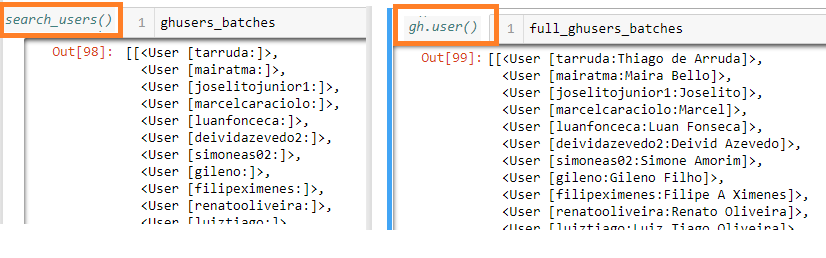

In [19]:
gh_users = create_users_df(full_ghusers_batches)

gh_followers = create_followers_df(full_ghusers_batches)

In [20]:
# aguardar API rate (em torno de 1h)
gh_repositories = create_repositories_df(full_ghusers_batches)

In [25]:
gh_users.head()

,User
0,tarruda
1,mairatma
2,joselitojunior1
3,marcelcaraciolo
4,luanfonceca


In [23]:
gh_users.describe()

,User
count,1992
unique,1981
top,Aennson
freq,2


In [26]:
gh_followers.head()

,All_Followers
0,"Sannis,danielmahon,csjaba,FergusRedican,Victor..."
1,"brunocoelho,henvic,eduardolundgren,aperrelli,a..."
2,"renatooliveira,jeffesonmaia,jotaefe,duartefq,J..."
3,"thiagoarrais,brunojm,henriquebastos,macndesign..."
4,"brunohenrique,luizvarela,gladson,lucasbibiano,..."


In [24]:
gh_followers.describe()

,All_Followers
count,1992
unique,1062
top,
freq,889


In [52]:
gh_repositories.head()

,Repo_Member,Repo_Owner
0,[libmpack/libmpack],"[tarruda/Algoritmos, tarruda/archdb, tarruda/b..."
1,"[deprecate/steel-avatar, deprecate/steel-cell-...","[mairatma/alloy-ui, mairatma/alloyui.com, mair..."
2,"[acmh/maecoruja, Cisneiros/projeto-anfa, demia...","[joselitojunior1/abigobaldo-nunes-adventures, ..."
3,"[irgmedeiros/TCCRecommender, jg1141/Open-Allur...","[marcelcaraciolo/apontador-api-libs, marcelcar..."
4,"[andrezap/analise_expressao_genica, andrezap/a...","[luanfonceca/168horas, luanfonceca/4stoq, luan..."


- **Obs.:**  
<font color='green'>\# ainda não se aplica ao caso </font>  
gh_repositories.describe()

In [61]:
gh_users_followers = gh_users.join(gh_followers)
gh_users_followers.head()

,User,All_Followers
0,tarruda,"Sannis,danielmahon,csjaba,FergusRedican,Victor..."
1,mairatma,"brunocoelho,henvic,eduardolundgren,aperrelli,a..."
2,joselitojunior1,"renatooliveira,jeffesonmaia,jotaefe,duartefq,J..."
3,marcelcaraciolo,"thiagoarrais,brunojm,henriquebastos,macndesign..."
4,luanfonceca,"brunohenrique,luizvarela,gladson,lucasbibiano,..."


In [29]:
gh_users_followers['nF'] = gh_users_followers['All_Followers'].apply(lambda x: (len(x) and len(x.split(','))) or len(x))

gh_users_followers.head()

,User,All_Followers,nF
0,tarruda,"Sannis,danielmahon,csjaba,FergusRedican,Victor...",570
1,mairatma,"brunocoelho,henvic,eduardolundgren,aperrelli,a...",363
2,joselitojunior1,"renatooliveira,jeffesonmaia,jotaefe,duartefq,J...",350
3,marcelcaraciolo,"thiagoarrais,brunojm,henriquebastos,macndesign...",330
4,luanfonceca,"brunohenrique,luizvarela,gladson,lucasbibiano,...",301


In [30]:
gh_users_followers.describe()

,nF
count,1992.000000
mean,6.074297
std,25.510528
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,570.000000


In [66]:
# linguagem do repositorio
gh_repositories['mRepo_Language'] = gh_repositories['Repo_Member'].apply(lambda x: ','.join([str(y.language) for y in x]))
gh_repositories['oRepo_Language'] = gh_repositories['Repo_Owner'].apply(lambda x: ','.join([str(y.language) for y in x]))

# normalizando
gh_repositories['Repo_Member'] = gh_repositories['Repo_Member'].apply(lambda x: ','.join([str(y) for y in x]))
gh_repositories['Repo_Owner']  =  gh_repositories['Repo_Owner'].apply(lambda x: ','.join([str(y) for y in x]))

gh_repositories = gh_repositories.reindex(['Repo_Member', 'mRepo_Language', 'Repo_Owner','oRepo_Language'], axis=1)

gh_repositories.head()

,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
0,libmpack/libmpack,C,"tarruda/Algoritmos,tarruda/archdb,tarruda/back...","JavaScript,JavaScript,JavaScript,JavaScript,Py..."
1,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","mairatma/alloy-ui,mairatma/alloyui.com,mairatm...","JavaScript,JavaScript,TypeScript,JavaScript,Ja..."
2,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None","joselitojunior1/abigobaldo-nunes-adventures,jo...","JavaScript,HTML,CSS,None,None,None,None,GCC Ma..."
3,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-DS","Python,Python","marcelcaraciolo/apontador-api-libs,marcelcarac...","PHP,Python,Python,None,Python,Python,Python,No..."
4,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","luanfonceca/168horas,luanfonceca/4stoq,luanfon...","CSS,Ruby,Python,JavaScript,Python,Python,None,..."


In [67]:
gh_users_repositories = gh_users.join(gh_repositories)

gh_users_repositories.head()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
0,tarruda,libmpack/libmpack,C,"tarruda/Algoritmos,tarruda/archdb,tarruda/back...","JavaScript,JavaScript,JavaScript,JavaScript,Py..."
1,mairatma,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","mairatma/alloy-ui,mairatma/alloyui.com,mairatm...","JavaScript,JavaScript,TypeScript,JavaScript,Ja..."
2,joselitojunior1,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None","joselitojunior1/abigobaldo-nunes-adventures,jo...","JavaScript,HTML,CSS,None,None,None,None,GCC Ma..."
3,marcelcaraciolo,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-DS","Python,Python","marcelcaraciolo/apontador-api-libs,marcelcarac...","PHP,Python,Python,None,Python,Python,Python,No..."
4,luanfonceca,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","luanfonceca/168horas,luanfonceca/4stoq,luanfon...","CSS,Ruby,Python,JavaScript,Python,Python,None,..."


In [31]:
# gh_users_followers.to_csv('temp_users_all-followers.csv', index=False) 
# gh_users_repositories.to_csv('temp_users_repositories.csv', index=False)

## Backup dos dados coletados no momento do scraping
**Note que o usuário pode não existir mais ou ter mudado o seu username, etc.**

In [ ]:
# Users trabalhados no projeto
backup_batch_df = pd.read_csv('temp_users_all-followers.csv')
b_ghusers_batch = backup_batch_df['User'].tolist()

# trata users nao encontrados
full_ghusers_batches2 = [[gh.user(x) for x in b_ghusers_batch if gh.user(x) is not None]]

gh_users2 = create_users_df(full_ghusers_batches2)

# atualiza os seguidores dos users
gh_followers2 = create_followers_df(full_ghusers_batches2)

In [ ]:
# aguardar API rate 
# atualiza os repositorios dos users
gh_repositories2 = create_repositories_df(full_ghusers_batches2)